In [30]:
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
# from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord  
from astropy.coordinates import FK5  
# from photutils.aperture import SkyEllipticalAperture, SkyRectangularAperture
# from photutils.aperture import aperture_photometry


## Importing fits files

### Importing CARMA Data

In [31]:
## [INPUT] filename of the fits cube
dir_data='/Users/donglinwu/Desktop/College/Research/'
filename = dir_data+'/CARMA_NRO_Orion_C18O.fits' #datafile

hdu = fits.open(filename)[0]
cube_header = hdu.header
cube_data = hdu.data


## [EDIT] change it according to the axes of the fits file
wcs = WCS(cube_header)
wcs2d = wcs[0,0,:,:] 
wcsv = wcs[0,:,0,0]

Set OBSGEO-B to    -0.986523 from OBSGEO-[XYZ].
Set OBSGEO-H to -6377200.288 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [32]:
## [INPUT] location of the protostar/center of the image
center = SkyCoord("5:35:22.2010899487 -6:13:06.1284437803", frame=FK5, unit=(u.hourangle, u.deg))
center_pixel = wcs2d.world_to_pixel(center)
print(center, center_pixel)

## [INPUT] distance to the source in parsec
d_source = 386.0

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (83.84250454, -6.21836901)> (array(1795.72547453), array(1851.50482879))


In [33]:
nu_o = cube_header['RESTFRQ']  #rest Frequency of the transition line from header (in Hz)
bmaj = cube_header['BMAJ'] * 3600. #beam major axis (in arcsec)
bmin = cube_header['BMIN'] * 3600. #beam major axis (in arcsec)
dv = cube_header['CDELT3'] # velocity resolution (velocity channel spacing) in m/s
dx = cube_header['CDELT1'] # length of pixel (in degrees)
dy = cube_header['CDELT2'] # width of pixel (in degrees)

In [34]:
## [INPUT] filename of the fits file for the mass of the core computed from the CARMA fits cube
## REQUIRED: this fits file should have the same spatial wcs axes as the fits cube

M_core_pixel = fits.open(dir_data+'/HOPS198/carma_mass_near_HOPS198.fits')[0].data

In [35]:
## [OPTIONAL] If only a section of the whole image is needed, use this part
half_width_image = 50
x1, x2 = int(round(center_pixel[0]-half_width_image,0)), int(round(center_pixel[0]+half_width_image,0))
y1, y2 = int(round(center_pixel[1]-half_width_image,0)), int(round(center_pixel[1]+half_width_image,0))
print(x1,x2,y1,y2)

## [OPTIONAL] If the entire image is needed, use this part
# x1, x2 = 0, cube_data.shape[3]
# y1, y2 = 0, cube_data.shape[2]

1746 1846 1802 1902


In [36]:
## [OPTIONAL] If the fits cube has more than two axes, this section is used to create celestial wcs axes so that the function add_beam can be used
celestial_hdu = fits.PrimaryHDU()
for i in range(len(list(hdu.header.keys()))):
    key = list(hdu.header.keys())[i]
    if '3' not in key and '4' not in key and 'COMMENT' not in key and 'HISTORY' not in key and key != '':
        celestial_hdu.header.update({key:hdu.header[key]})
celestial_hdu.header.update({'NAXIS':2})

### Importing ALMA Data

In [37]:
## [INPUT] filename of the mass of core computed from the ALMA fits cube

hdu_core = fits.open(dir_data+'/HOPS198/HOPS198_12CO_core_mass.fits')[0]
M_core_pixel_ALMA = hdu_core.data
wcs_ALMA = WCS(hdu_core.header)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [38]:
# Coordinates of the center in the ALMA wcs axes
center_ALMA = wcs_ALMA.world_to_pixel(center)
print(center, center_ALMA)

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (83.84250454, -6.21836901)> (array(222.15007111), array(224.42091879))


In [39]:
## [INPUT] filename of the mass of outflow computed from the ALMA fits cube

hdu_outflow = fits.open(dir_data+'/HOPS198/outflow/HOPS198_12CO_outflow_mass_order5_nrect_20.fits')[0]
M_outflow_pixel = hdu_outflow.data

## Polar Coordinates

### CARMA Core

In [11]:
from matplotlib import colors
from regions import PixCoord, LineSkyRegion, LinePixelRegion
from astropy.visualization.wcsaxes import add_beam
from scipy.interpolate import griddata
from matplotlib.colors import PowerNorm, LogNorm



## Function: converts cartesian coordinates to radial coordinates

def cartesian_to_polar(x, y, z, x_center, y_center, x_ray, y_ray):
    # x, y: 1-dim array that represents the cartesian grid coordinates 
    # z: 2-dim array (the data)
    # x_center, y_center: coordinates of the center of the polar coordinate
    # x_ray, y_ray: coordinates of a reference point; 
    #       the line from (x_center, y_center) to this point defines the zero-angle direction (θ = 0) in the polar coordinate system
    #
    # returns r_grid: 1-dim array that represents the radial coordinate of the polar coordinate
    #         theta_grid: 1-dim array that represents the angular coordinate of the polar coordinate
    #         z_polar: 2-dim array under the polar coordinate

    # Create a meshgrid for x and y
    x_grid, y_grid = np.meshgrid(x, y, indexing='xy')
    
    # Compute the difference in x and y from the center
    x_diff = x_grid - x_center
    y_diff = y_grid - y_center
    
    # Compute the ray direction and normalize it
    ray_direction = np.array([x_ray - x_center, y_ray - y_center])
    ray_direction = ray_direction / np.linalg.norm(ray_direction)
    
    # Compute the distances r
    r = np.sqrt(x_diff**2 + y_diff**2)
    
    # Compute the angles theta
    theta = np.arctan2(y_diff, x_diff) - np.arctan2(ray_direction[1], ray_direction[0])
    
    # Ensure theta is in the range [0, 2*pi)
    theta = np.mod(theta, 2 * np.pi)
    
    # Flatten the arrays for interpolation and filter out NaNs
    valid_mask = ~np.isnan(z)
    points = np.vstack((r[valid_mask], theta[valid_mask])).T
    values = z[valid_mask]
    
    # Create a polar grid
    r_max = np.max(r)
    r_grid, theta_grid = np.meshgrid(np.linspace(0, r_max, z.shape[0]), 
                                     np.linspace(0, 2 * np.pi, z.shape[1]), indexing='ij')
    
    # Interpolate z values onto the polar grid
    z_polar = griddata(points, values, (r_grid, theta_grid), method='cubic', fill_value=np.nan)
    
    return r_grid, theta_grid, z_polar

In [12]:
## Function: returns area of a pixel in centimeter squared
def A_pixel_pc(d_source, dx_pixel, dy_pixel):
    # d_source in parsec
    # dx_pixel, dy_pixel: length and width of pixel in degrees
    # returns area of pixel in cm^2
    return abs(dx_pixel*dy_pixel)*pow(np.pi/180, 2)*pow(d_source,2)

In [13]:
## [INPUT] The reference point that defines the zero-angle direction of the polar coordinate

point_ref = SkyCoord("5:35:20.5708706819 -6:11:55.2089173640", frame=FK5, unit=(u.hourangle, u.deg))
c_ray = wcs2d.world_to_pixel(point_ref)
x_ray, y_ray = c_ray[0], c_ray[1]

In [14]:
#### Converts the data from cartesian coordinates to polar coordinates

## The data we are computing here is surface density, therefore the function A_pixel_pc is used
z = M_core_pixel[y1:y2,x1:x2]/A_pixel_pc(d_source,dx,dy) 


x = np.arange(x1, x2)
y = np.arange(y1, y2)
x_center, y_center = center_pixel[0], center_pixel[1]

## Applies the functions
r_grid, theta_grid, z_polar = cartesian_to_polar(x, y, z, x_center, y_center, x_ray, y_ray)

Set OBSGEO-B to    -0.986523 from OBSGEO-[XYZ].
Set OBSGEO-H to -6377200.288 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/nt/5v93q0kd53nb6_gdg84kfk5w0000gn/T/ipykernel_54757/342081525.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


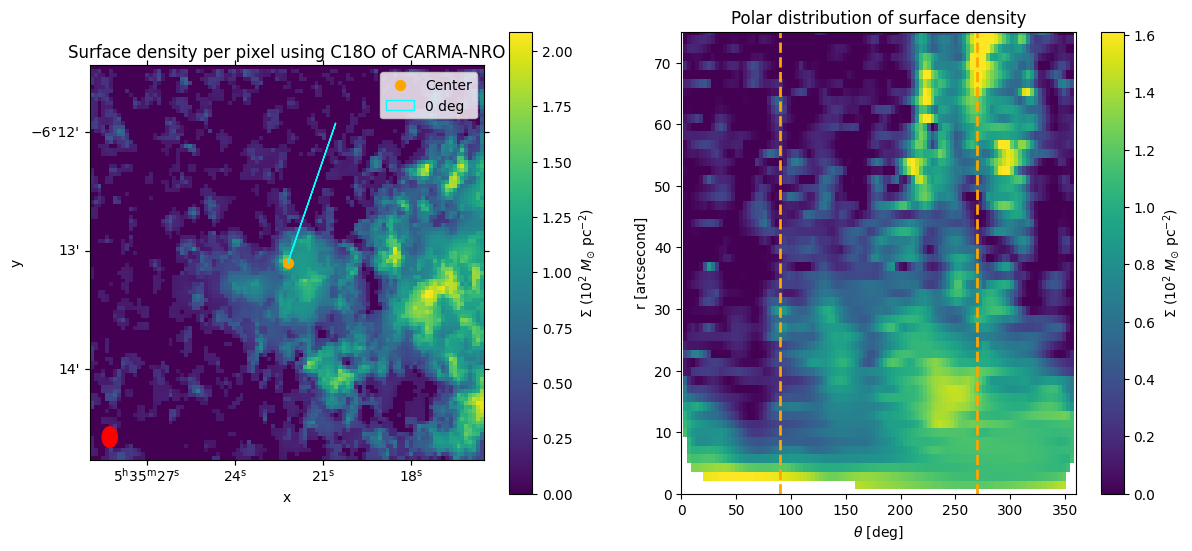

In [15]:
#### Visualizes the data in polar coordinates

## Plot the original Cartesian data
fig = plt.figure(figsize=(14, 6))

## First subplot: Surface Density Map
ax = plt.subplot(1, 2, 1, projection=WCS(celestial_hdu), aspect='equal')
im = ax.pcolormesh(x, y, z/100, shading='auto')
cbar = plt.colorbar(im, ax=ax, label=r'$\Sigma$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')

## Contour overlay: plots relevant contours if necessary
## REQUIRED: the contours should be 2-dimensional arrays with same shape as z_polar (the polar coordinate grids)
# ax.contour()

## Labels and title
ax.set_title('Surface density per pixel using C18O of CARMA-NRO')
ax.set_xlabel('x')
ax.set_ylabel('y')

## Scatter relevant points
# The center
ax.scatter([x_center], [y_center], color='orange', s=50, label='Center')
# The reference point
# ax.scatter([x_ray], [y_ray], color='green', s=50, label='Ray point')

## Beam annotation
add_beam(ax, major=celestial_hdu.header['BMAJ'], minor=celestial_hdu.header['BMIN'], angle=celestial_hdu.header['BPA'], color='red')

## Label the zero-angle direction with a line
LinePixelRegion(start=PixCoord(x_center, y_center), end=PixCoord(x_ray, y_ray)).plot(ax=ax, color='cyan', label='0 deg')

ax.legend()



## Second subplot: Polar Plot
ax_polar = plt.subplot(1, 2, 2)
## [INPUT] Change the scale of the colormap if necessary
im_polar = ax_polar.pcolormesh(theta_grid/np.pi*180, r_grid*(dy*3600), z_polar/100, 
                                norm=colors.Normalize(vmin=0, vmax=np.nanmax(z_polar[:20, :]/100)), 
                                shading='auto')

plt.colorbar(im_polar, ax=ax_polar, label=r'$\Sigma$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')

## Vertical dashed lines
ax_polar.vlines([90, 270], ymin=0, ymax=75, linestyles='dashed', color='orange', linewidths=2)
## theta_offset = (211.82662257274978 - 161.08900082069863)
## ax_polar.vlines([theta_offset, 180 + theta_offset], ymin=0, ymax=75, linestyles='dashed', color='white', linewidths=1.2)

## Labels and limits
ax_polar.set_title('Polar distribution of surface density')
ax_polar.set_xlabel(r'$\theta$ [deg]')
ax_polar.set_ylabel('r [arcsecond]')
ax_polar.set_xlim(0, 360)
ax_polar.set_ylim(0, 75)

plt.tight_layout()
plt.show()


In [16]:
## [OPTIONAL] A larger image for the polar plot

# fig = plt.figure(figsize=(10, 6))
# ax_polar = plt.subplot(1, 1, 1)
# im_polar = ax_polar.pcolormesh(theta_grid/np.pi*180, r_grid*(dy*3600), z_polar/100, 
#                                 norm=colors.Normalize(vmin=0, vmax=np.nanmax(z_polar[:20, :]/100)), 
#                                 shading='auto')

# plt.colorbar(im_polar, ax=ax_polar, label=r'$\Sigma_{H_2}$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')

# # Vertical dashed lines
# ax_polar.vlines([90, 270], ymin=0, ymax=75, linestyles='dashed', color='orange', linewidths=2)
# # theta_offset = (211.82662257274978 - 161.08900082069863)
# # ax_polar.vlines([theta_offset, 180 + theta_offset], ymin=0, ymax=75, linestyles='dashed', color='white', linewidths=1.2)

# # Labels and limits
# # ax_polar.set_title('Polar distribution of surface density')
# ax_polar.set_xlabel(r'$\theta$ [deg]')
# ax_polar.set_ylabel('r [arcsecond]')
# ax_polar.set_xlim(0, 360)
# ax_polar.set_ylim(0, 75)

# plt.tight_layout()
# plt.show()

### ALMA Core

In [17]:
## Same reference point for the zero-angle direction as the CARMA data
c_ray_ALMA = wcs_ALMA.world_to_pixel(point_ref)
x_ray, y_ray = c_ray_ALMA[0], c_ray_ALMA[1]
print(x_ray, y_ray)

365.1518967152192 641.5937009251322


In [18]:
#### Converts the data from cartesian coordinates to polar coordinates for ALMA
x = np.arange(0, 448)
y = np.arange(0, 448)
z = M_core_pixel_ALMA/A_pixel_pc(d_source,hdu_core.header['CDELT1'],hdu_core.header['CDELT2']) # Replace with your actual z values
x_center, y_center = center_ALMA[0], center_ALMA[1]
r_grid_ALMA, theta_grid_ALMA, M_core_polar_ALMA = cartesian_to_polar(x, y, z, x_center, y_center, x_ray, y_ray)

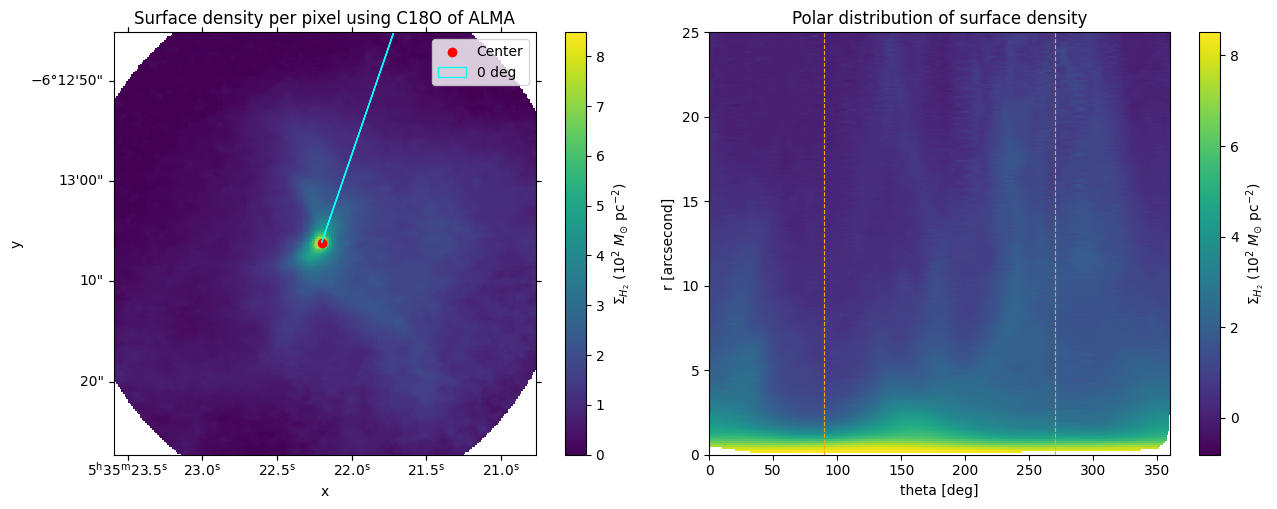

In [19]:
#### Visualizes the data in polar coordinates

plt.figure(figsize=(14, 6))

# First subplot (WCS projection)
ax1 = plt.subplot(1, 2, 1, projection=wcs_ALMA, aspect='equal')
im = plt.pcolormesh(x, y, z/100, shading='auto')
cbar = plt.colorbar(im, ax=ax1, label=r'$\Sigma_{H_2}$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')
ax1.set_title('Surface density per pixel using C18O of ALMA')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.scatter([x_center], [y_center], color='red', label='Center')
# ax1.scatter([x_ray], [y_ray], color='green', label='Ray point')
LinePixelRegion(start=PixCoord(x_center, y_center), end=PixCoord(x_ray, y_ray)).plot(color='cyan', label='0 deg')

# Add beam to the first subplot
add_beam(ax, major=hdu_core.header['BMAJ'], minor=hdu_core.header['BMIN'], angle=hdu_core.header['BPA'], color='red')

ax1.set_xlim(100, 448 - 100)
ax1.set_ylim(100, 448 - 100)
ax1.legend()

# Second subplot (polar plot)
ax2 = plt.subplot(1, 2, 2)
im2 = plt.pcolormesh(theta_grid_ALMA/np.pi*180, r_grid_ALMA*(hdu_core.header['CDELT2']*3600), M_core_polar_ALMA/100, shading='auto') #PowerNorm(gamma=0.5)
cbar = plt.colorbar(im2, ax=ax2, label=r'$\Sigma_{H_2}$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')
ax2.vlines(x=90, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=0.8)
ax2.vlines(x=270, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=0.8)
ax2.set_title('Polar distribution of surface density')
ax2.set_xlabel('theta [deg]')
ax2.set_ylabel('r [arcsecond]')
ax2.set_ylim(0, 25)
ax2.set_xlim(0, 360)

plt.tight_layout()
plt.show()



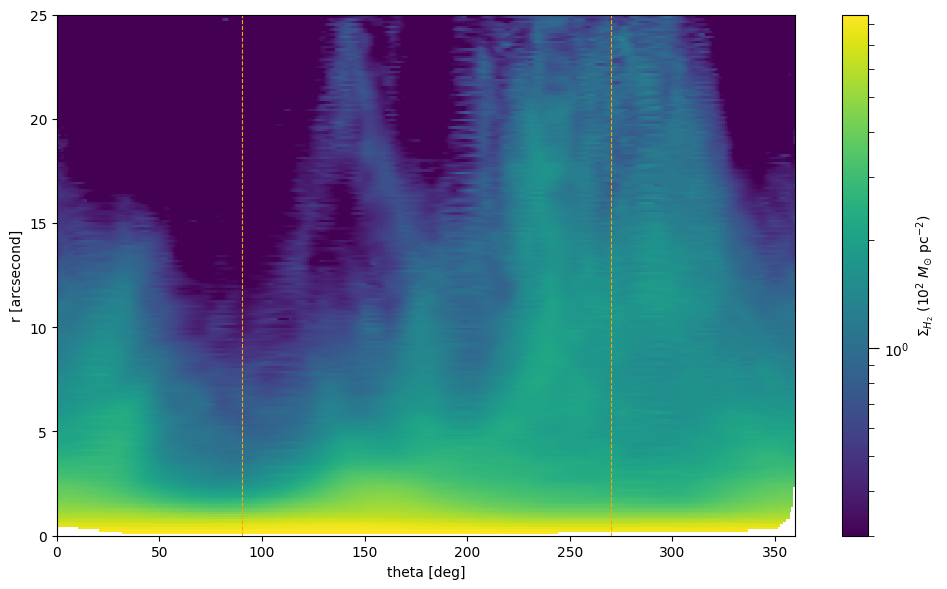

In [20]:
## [OPTIONAL] A larger image for the polar plot with LogNorm colorbar

fig = plt.figure(figsize=(10, 6))

M_core_polar_ALMA[M_core_polar_ALMA <= 0] = 1e-90

ax2 = plt.subplot(1, 1, 1)
im2 = plt.pcolormesh(theta_grid_ALMA/np.pi*180, r_grid_ALMA*(hdu_core.header['CDELT2']*3600), M_core_polar_ALMA/100, shading='auto', norm=LogNorm(vmin=3e-1,vmax=np.nanmax(M_core_polar_ALMA/100))) #PowerNorm(gamma=0.5)
cbar = plt.colorbar(im2, ax=ax2, label=r'$\Sigma_{H_2}$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')
cbar.ax.tick_params(length=8)
cbar.ax.tick_params(length=4, which='minor')  # Increase length of secondary ticks
ax2.vlines(x=90, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=0.8)
ax2.vlines(x=270, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=0.8)
# ax2.set_title('Polar distribution of surface density')
ax2.set_xlabel('theta [deg]')
ax2.set_ylabel('r [arcsecond]')
ax2.set_ylim(0, 25)
ax2.set_xlim(0, 360)

plt.tight_layout()
plt.show()

### ALMA Outflow

In [21]:
## [OPTIONAL] mask for outflow data when it contains NaN
mask_image = np.zeros(shape=(M_core_pixel_ALMA.shape[0],M_core_pixel_ALMA.shape[1]))
mask_image[np.isnan(M_core_pixel_ALMA[:,:]) == False] = 1
mask_image[np.isnan(M_core_pixel_ALMA[:,:]) == True] = np.nan

In [22]:
## Same reference point for the zero-angle direction as the ALMA core data

c_ray_ALMA = wcs_ALMA.world_to_pixel(point_ref)
x_ray, y_ray = c_ray_ALMA[0], c_ray_ALMA[1]

In [23]:
#### Converts the data from cartesian coordinates to polar coordinates for ALMA outflow
x = np.arange(0, 448)
y = np.arange(0, 448)
z = mask_image*hdu_outflow.data/A_pixel_pc(d_source,hdu_core.header['CDELT1'],hdu_core.header['CDELT2']) # Replace with your actual z values
x_center, y_center = center_ALMA[0], center_ALMA[1]
r_grid_ALMA, theta_grid_ALMA, M_outflow_polar_ALMA = cartesian_to_polar(x, y, z, x_center, y_center, x_ray, y_ray)

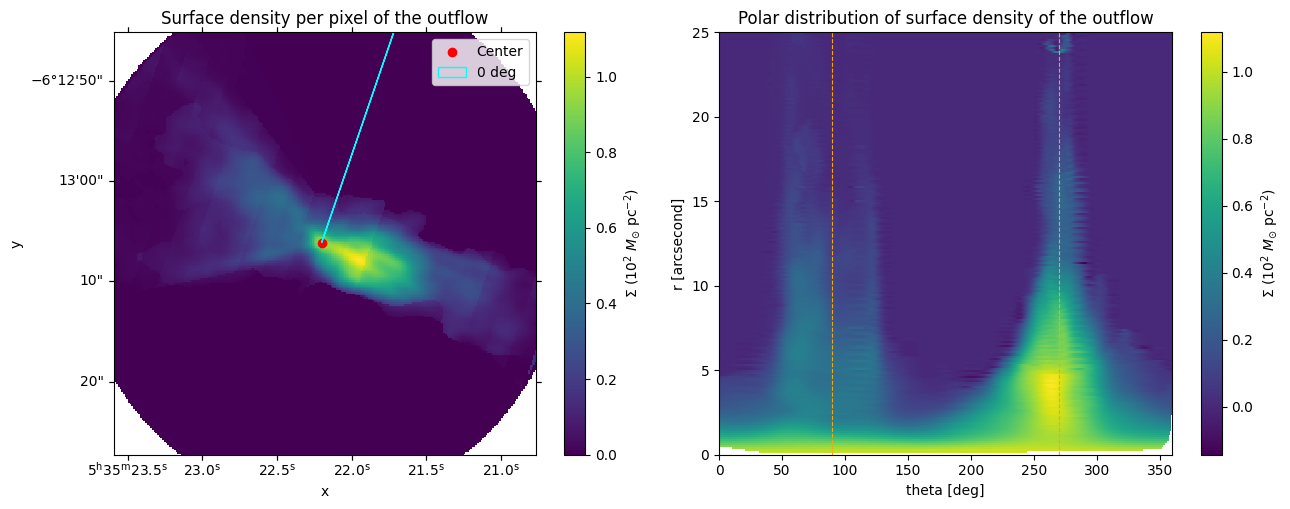

In [24]:
#### Visualizes the data in polar coordinates
# Plot the original Cartesian data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1, projection=wcs_ALMA, aspect='equal')
plt.pcolormesh(x, y, z/100, shading='auto')
plt.colorbar(label=r'$\Sigma$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')
plt.title('Surface density per pixel of the outflow')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter([x_center], [y_center], color='red', label='Center')
# plt.scatter([x_ray], [y_ray], color='green', label='Ray point')
LinePixelRegion(start=PixCoord(x_center, y_center), end=PixCoord(x_ray, y_ray)).plot(color='cyan', label='0 deg')

plt.xlim(100,448-100)
plt.ylim(100,448-100)
plt.legend()

# Plot the polar data
plt.subplot(1, 2, 2)
plt.pcolormesh(theta_grid_ALMA/np.pi*180, r_grid_ALMA*(hdu_core.header['CDELT2']*3600), M_outflow_polar_ALMA/100, shading='auto')
plt.colorbar(label=r'$\Sigma$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')
plt.title('Polar distribution of surface density of the outflow')
plt.vlines(x=90,ymin=0, ymax=40, linestyles='dashed',color='orange', linewidths=0.8)
plt.vlines(x=270,ymin=0, ymax=40, linestyles='dashed',color='orange', linewidths=0.8)
plt.xlabel('theta [deg]')
plt.ylabel('r [arcsecond]')
plt.ylim(0, 25)
plt.xlim(0, 360)

plt.tight_layout()
plt.show()


(100.0, 348.0)

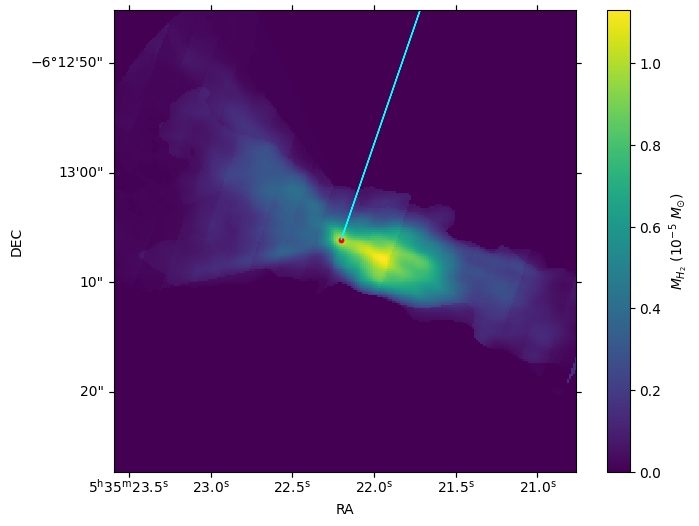

In [25]:
## [OPTIONAL] A larger image for the cartesian plot
point_ref_new = SkyCoord("5:35:21.6553271316 -6:12:42.4521548175", frame=FK5, unit=(u.hourangle, u.deg))
c_ray_ALMA = wcs_ALMA.world_to_pixel(point_ref_new)
x_ray, y_ray = c_ray_ALMA[0], c_ray_ALMA[1]

fig = plt.figure(figsize=(8, 6))

# First subplot (WCS projection)
ax1 = plt.subplot(1, 1, 1, projection=wcs_ALMA, aspect='equal')
im1 = ax1.pcolormesh(x, y, hdu_outflow.data*1e5, shading='auto')
# Manually create the colorbar for ax1
cbar1 = plt.colorbar(im1, ax=ax1, label=r'$M_{H_2}$ (10$^{-5}$ $M_{\odot}$)')
# ax1.set_title('Surface density per pixel of the outflow')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.scatter([x_center], [y_center], color='red', label='Center', s=10)
# ax1.scatter([x_ray], [y_ray], color='green', label='Ray point')
LinePixelRegion(start=PixCoord(x_center, y_center), end=PixCoord(x_ray, y_ray)).plot(color='cyan', label='0 deg')

ax1.set_xlim(100, 448 - 100)
ax1.set_ylim(100, 448 - 100)
# ax1.legend()


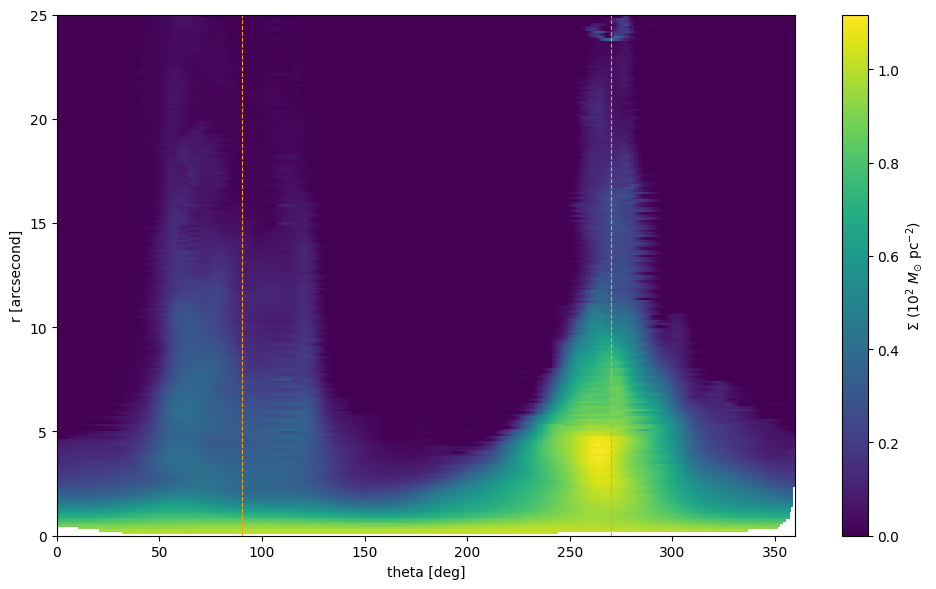

In [26]:
## [OPTIONAL] A larger image for the polar plot
fig = plt.figure(figsize=(10, 6))
# Second subplot (polar plot)
ax2 = plt.subplot(1, 1, 1)
im2 = ax2.pcolormesh(theta_grid_ALMA/np.pi*180, r_grid_ALMA*(hdu_core.header['CDELT2']*3600), M_outflow_polar_ALMA/100, shading='auto', vmin=0)
# Manually create the colorbar for ax2
cbar2 = plt.colorbar(im2, ax=ax2, label=r'$\Sigma$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')
ax2.vlines(x=90, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=0.8)
ax2.vlines(x=270, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=0.8)
# ax2.set_title('Polar distribution of surface density of the outflow')
ax2.set_xlabel('theta [deg]')
ax2.set_ylabel('r [arcsecond]')
ax2.set_ylim(0, 25)
ax2.set_xlim(0, 360)

plt.tight_layout()
plt.show()




### Comparison

In [27]:
## Defines a single-color colormap

from matplotlib.colors import LogNorm, ListedColormap
# Define the color you want to use (e.g., white)
color = (1, 1, 1)  # RGB tuple for white
# Create a custom colormap with a single color
single_color_cmap = ListedColormap([color])

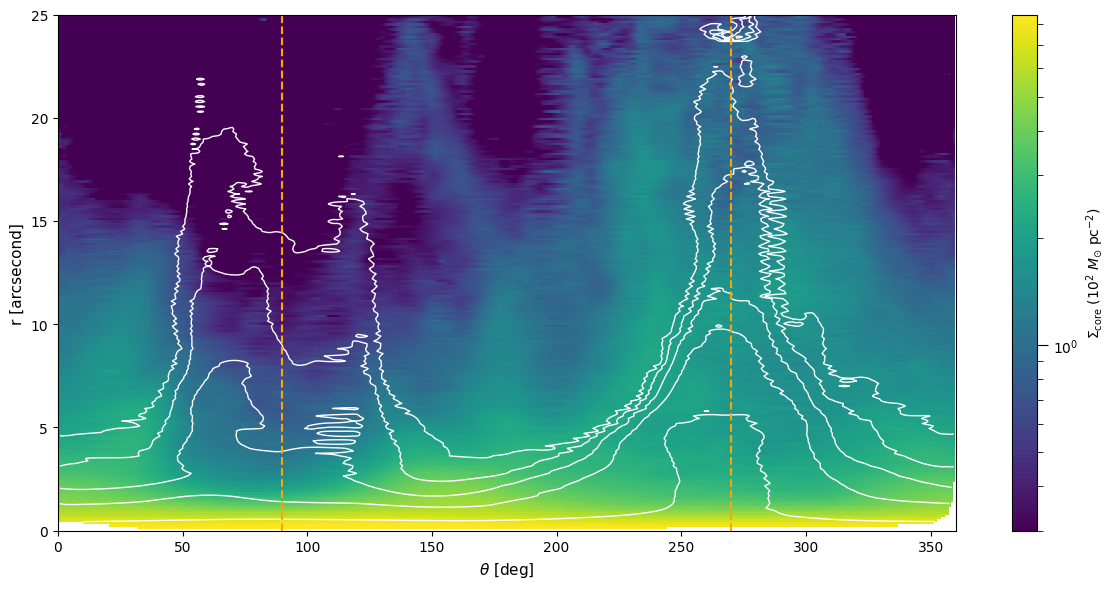

In [28]:


#### Compares the mass of the outflow and mass of the core 
## Contours: mass of the outflow
## Images: mass of the core



fig = plt.figure(figsize=(12, 6))

# Contour plot with single-color colormap for the mass of the outflow
plt.contour(
    theta_grid_ALMA/np.pi*180, 
    r_grid_ALMA*(hdu_core.header['CDELT2']*3600), 
    M_outflow_polar_ALMA/100, 
    levels=np.array([0.05, 0.15, 0.3, 0.5, 0.8]) * np.nanmax(M_outflow_polar_ALMA) /100, 
    cmap=single_color_cmap, 
    linewidths=1
)

# pcolormesh plot with logarithmic color normalization for the mass of the core
im = plt.pcolormesh(
    theta_grid_ALMA/np.pi*180, 
    r_grid_ALMA*(hdu_core.header['CDELT2']*3600), 
    M_core_polar_ALMA/100, 
    shading='auto', 
    norm=LogNorm(vmin=3e-1, vmax=np.nanmax(M_core_polar_ALMA/100))
)

# Explicitly store colorbar object
cbar = plt.colorbar(im, label=r'$\Sigma_{\text{core}}$ ($10^{2}~M_{\odot}$ pc$^{-2}$)')

# Modify tick parameters for primary and secondary ticks
cbar.ax.tick_params(length=8)  # Primary ticks
cbar.ax.tick_params(length=4, which='minor')  # Secondary ticks

# Vertical dashed lines
plt.vlines(x=90, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=1.5)
plt.vlines(x=270, ymin=0, ymax=40, linestyles='dashed', color='orange', linewidths=1.5)

# Labels and limits
plt.xlabel(r'$\theta$ [deg]', fontsize=11)
plt.ylabel(r'r [arcsecond]', fontsize=11)
plt.ylim(0, 25)
plt.xlim(0, 360)

plt.tight_layout()
plt.show()

